In [1]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import vae
import data

# Use LaTeX-style formatting
plt.rcParams.update({
    "figure.figsize": (3, 2),  # Width, Height in inches
    "figure.dpi": 300,
    "font.family": "serif",
    "font.size": 6,
    "axes.linewidth": 1.5,
    "xtick.direction": "in",
    "ytick.direction": "in"
})

In [ ]:
# # Creates shape random shape data.
# shape_data = data.Generator(resolution=200,num_shapes=500000).generate_shapes()

# file_path = os.path.join(r'/Users/joshuahellewell/Desktop/02-msc/01-modules/MSc Project - 771952/03-results/data','shapes500k.pkl'),
# # Assume `shapes` is a list of shape objects
# with open(file_path[0], "wb") as f:
#     pickle.dump(shape_data, f)

In [2]:
df = pd.read_csv(r'/Users/joshuahellewell/Desktop/02-msc/01-modules/MSc Project - 771952/03-results/models/test_matrix.csv')
df.head(10)

,model_name,data,latent_dim,batch_size,activation,lr
0,model_001,/Users/joshuahellewell/Desktop/02-msc/01-modul...,2,256,relu,0.0010
1,model_002,/Users/joshuahellewell/Desktop/02-msc/01-modul...,2,512,relu,0.0010
2,model_003,/Users/joshuahellewell/Desktop/02-msc/01-modul...,2,256,relu,0.0001
3,model_004,/Users/joshuahellewell/Desktop/02-msc/01-modul...,2,512,relu,0.0001


In [2]:
with open('/Users/joshuahellewell/Desktop/02-msc/01-modules/MSc Project - 771952/03-results/data/shapes100k.pkl', 'rb') as f:
        shapes = pickle.load(f)

In [6]:
for i,j in df.iterrows():
    with open(j['data'], 'rb') as f:
        shapes = pickle.load(f)

    dataset = vae.ShapeData(shapes)

    model = vae.VAE(200*2,j['latent_dim'])

    # Initialises model trainer.
    trainer = vae.Trainer(dataset,model,base_dir=r'/Users/joshuahellewell/Desktop/02-msc/01-modules/MSc Project - 771952/03-results/models',trained_data=j['data'],model_name=j['model_name'],batch_size=j['batch_size'])
    trainer.train_model(1000,200)

Epoch 1, Loss: 9459.896484375
Epoch 2, Loss: 5299.778936624527
Epoch 3, Loss: 4055.497666120529
Epoch 4, Loss: 4027.9904956817627
Epoch 5, Loss: 3827.0098793506622
Epoch 6, Loss: 3383.962877035141
Epoch 7, Loss: 3454.280419588089
Epoch 8, Loss: 3267.771436691284
Epoch 9, Loss: 3487.2688632011414
Epoch 10, Loss: 2986.1663892269135
Epoch 11, Loss: 2985.2369487285614
Epoch 12, Loss: 2966.319129705429
Epoch 13, Loss: 3222.502601146698
Epoch 14, Loss: 2998.844021320343
Epoch 15, Loss: 2946.387836933136
Epoch 16, Loss: 2851.6051523685455
Epoch 17, Loss: 2826.0881078243256
Epoch 18, Loss: 2819.3400235176086
Epoch 19, Loss: 2882.959161043167
Epoch 20, Loss: 2646.338136911392
Epoch 21, Loss: 2733.9699449539185
Epoch 22, Loss: 3003.0587408542633
Epoch 23, Loss: 2805.230628013611
Epoch 24, Loss: 2751.0446622371674
Epoch 25, Loss: 2654.6637246608734
Epoch 26, Loss: 2552.8044753074646
Epoch 27, Loss: 2639.4242963790894
Epoch 28, Loss: 2735.6651990413666
Epoch 29, Loss: 2507.3521268367767
Epoch 30, 

In [3]:
test_shapes = data.Generator(resolution=200,num_shapes=5).generate_shapes()

dt = [torch.tensor(shape.points, dtype=torch.float32).view(-1) for shape in test_shapes]
# # Plot 3 random shapes side by side
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# # fig.suptitle('Random Shape Examples', fontsize=14)

# # Get 3 random indices
# random_indices = np.random.choice(len(dt), size=3, replace=False)

# for idx, ax in enumerate(axes):
#     # Get random shape and reshape to 2D coordinates
#     shape = dt[random_indices[idx]]  # This should give us a tensor of shape (1,400)
    
#     orig_shape = shape.squeeze(0).numpy().reshape(-1,2)
#     ax.plot(orig_shape[:, 0], orig_shape[:, 1], 'o-', label="Original")
    

    
# plt.tight_layout()
# plt.show()

100%|██████████| 5/5 [00:00<00:00, 2128.44it/s]


### Obtain Z-values for all training dataset.

In [4]:
model = torch.load(r'/Users/joshuahellewell/Desktop/02-msc/01-modules/MSc Project - 771952/03-results/models/01042025_training/model_003/vae_epoch_1000_mse2118.2.pt')

/var/folders/g6/cp4y9yrj70746qd9t6j1yj2r0000gn/T/ipykernel_95232/3832146851.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(r'/Users/joshuahellewell/D

-2.9038389 3.5989647
-3.855856 3.6617637


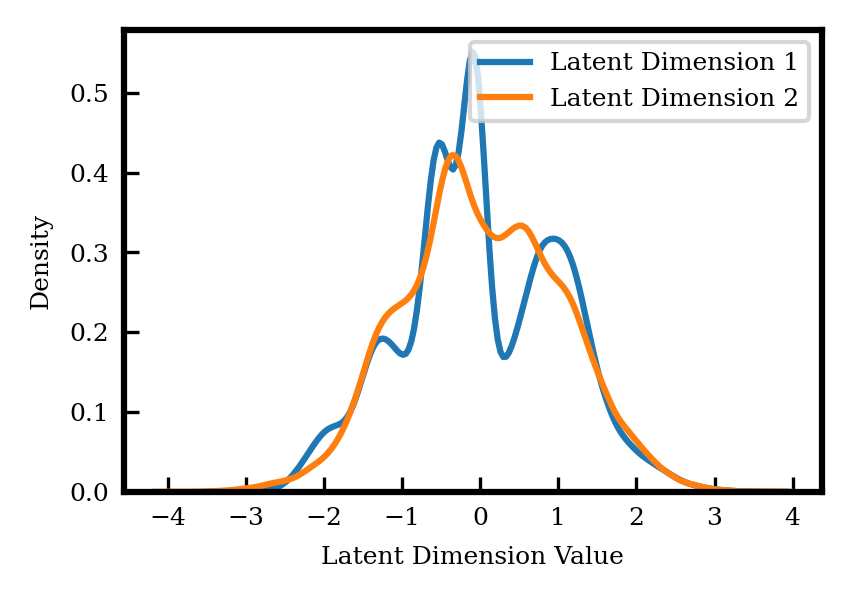

In [7]:
with open('/Users/joshuahellewell/Desktop/02-msc/01-modules/MSc Project - 771952/03-results/data/shapes100k.pkl', 'rb') as f:
        shapes = pickle.load(f)

sh = [torch.tensor(shape.points, dtype = torch.float32).view(-1) for shape in shapes]


z_values = []
for i in sh:
    with torch.no_grad():
        x = model.encoder(i)  # Encoder block.
        mu,logvar = model.fc_mu(x),model.fc_logvar(x)  # Mu & Logvar for latent layer.
        z = model.reparameterise(mu,logvar)  # Obtain latent variables.
        z_values.append(z.detach().numpy())

z_values = np.array(z_values)   

z1 = z_values[:,0]
z2 = z_values[:,1]

print(z1.min(),z1.max())
print(z2.min(),z2.max())


sns.kdeplot(z1,label = 'Latent Dimension 1')
sns.kdeplot(z2,label = 'Latent Dimension 2')
plt.xlabel('Latent Dimension Value')
plt.legend()

(200, 2)


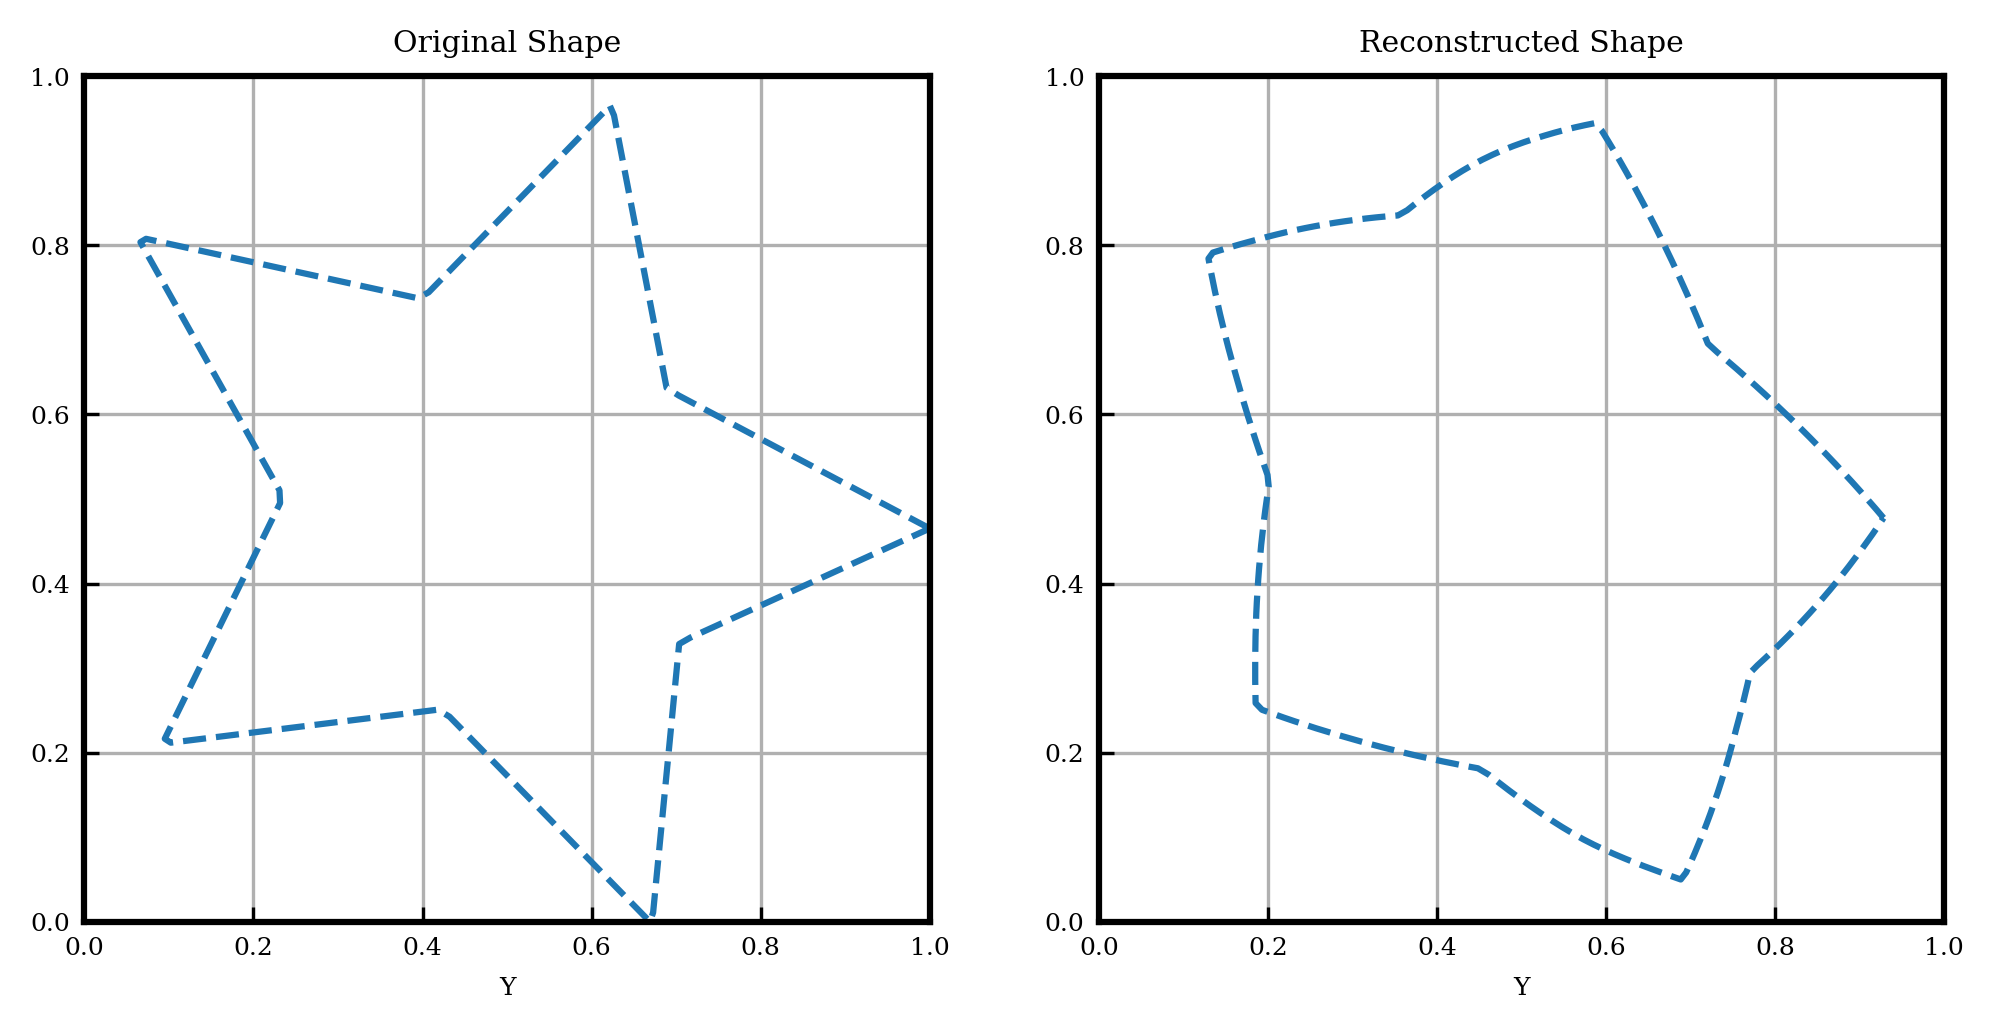

(200, 2)


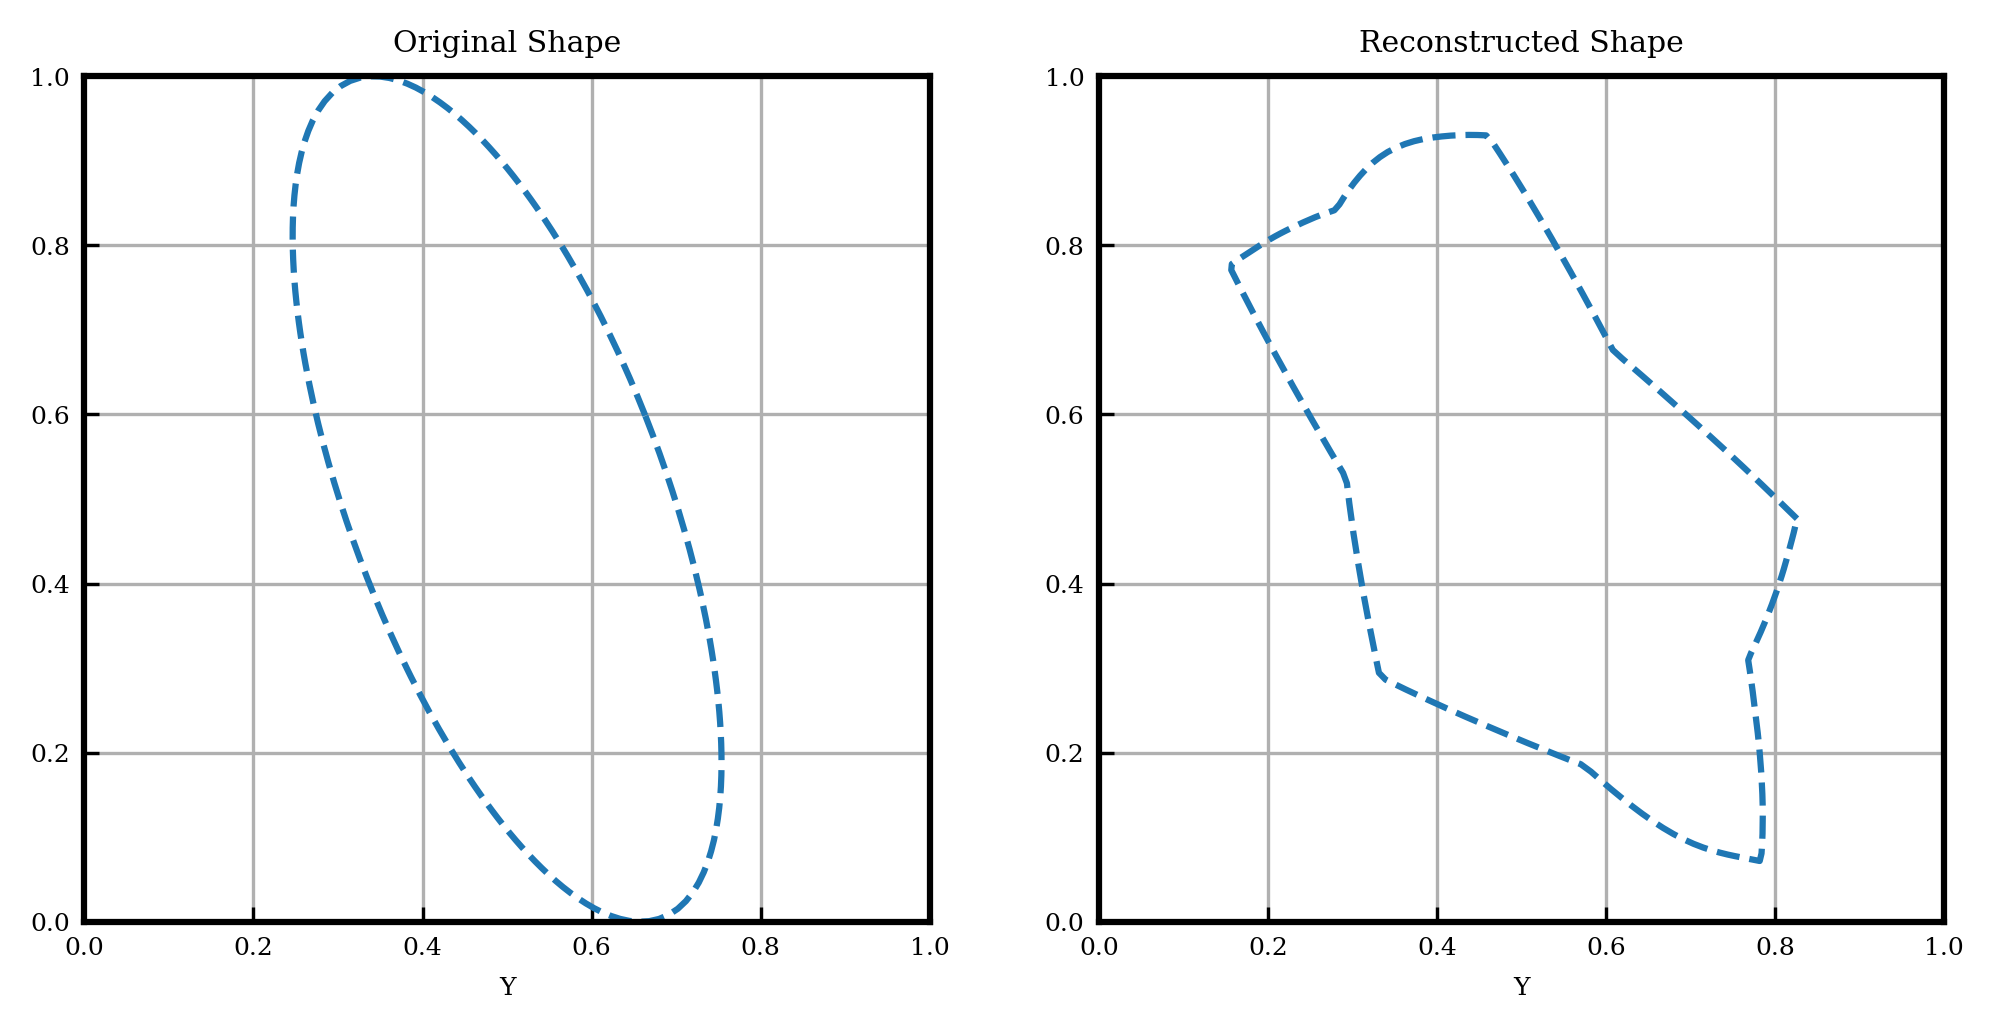

(200, 2)


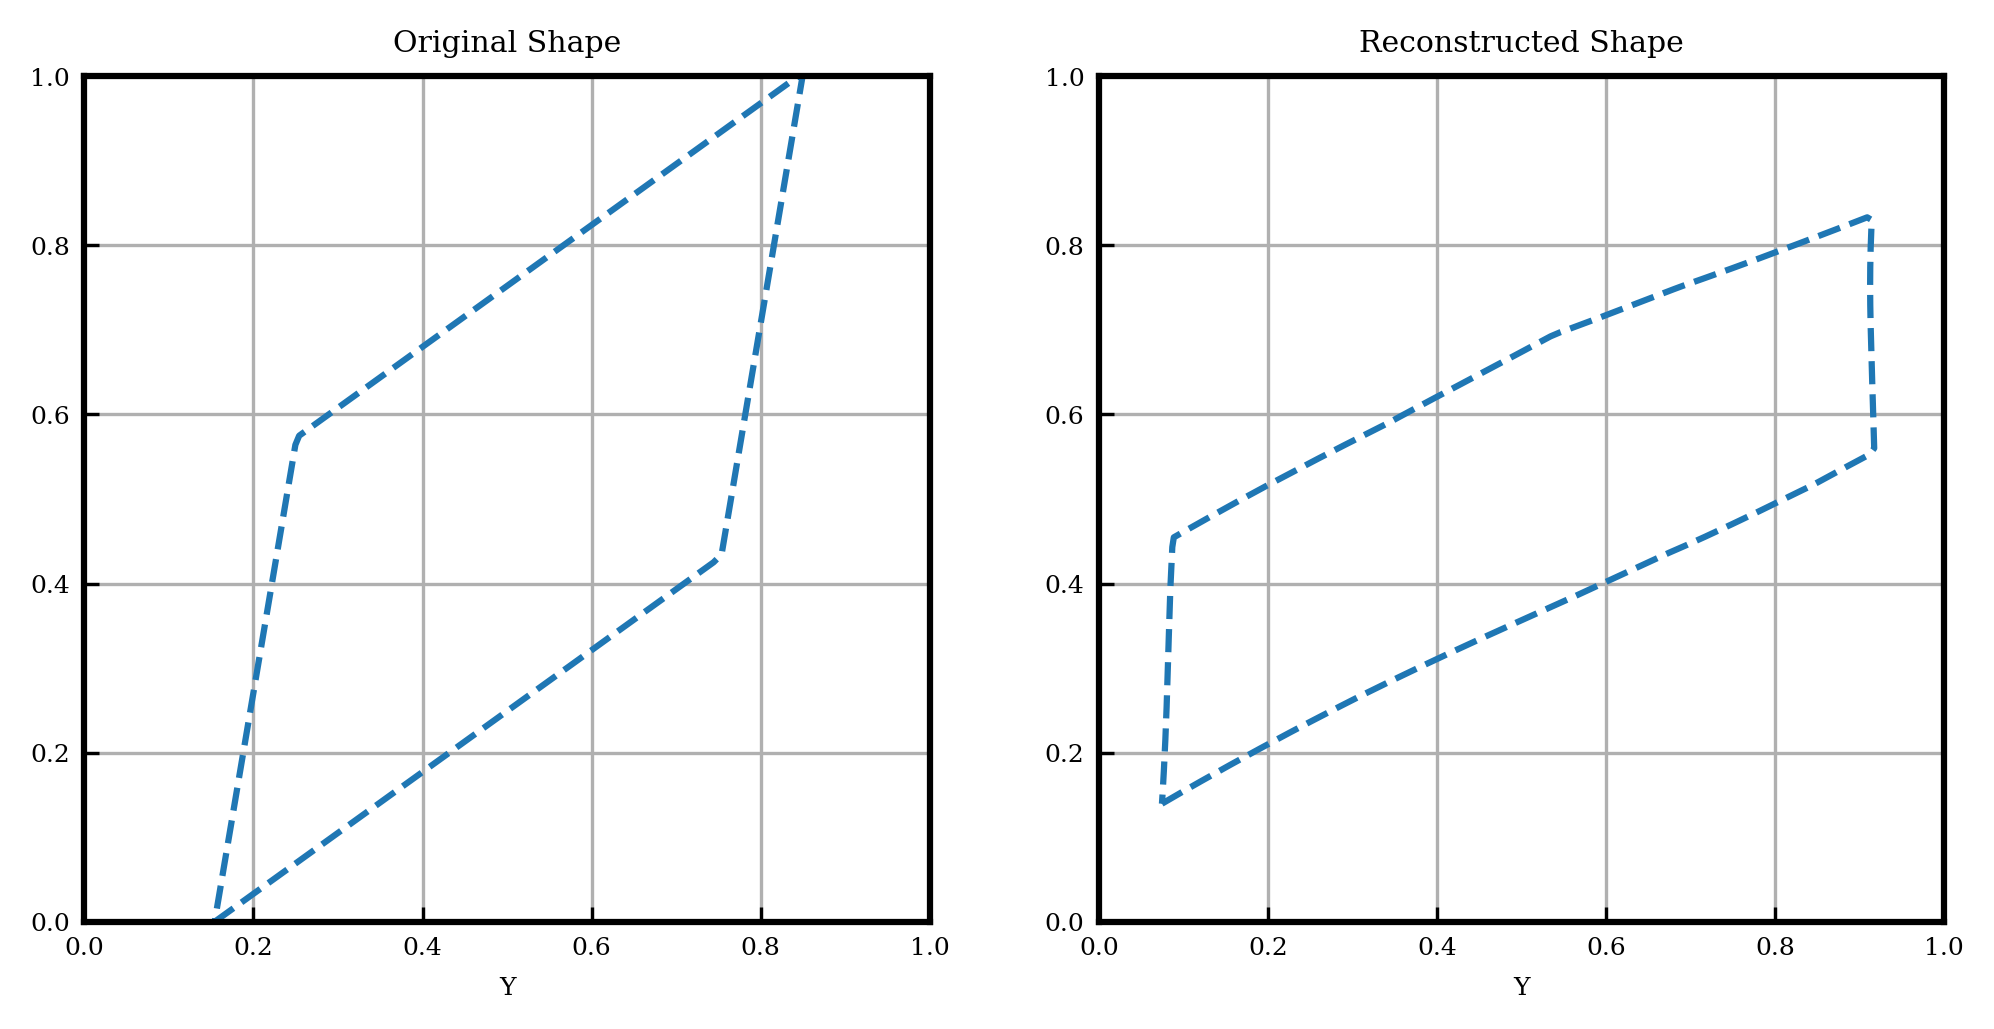

(200, 2)


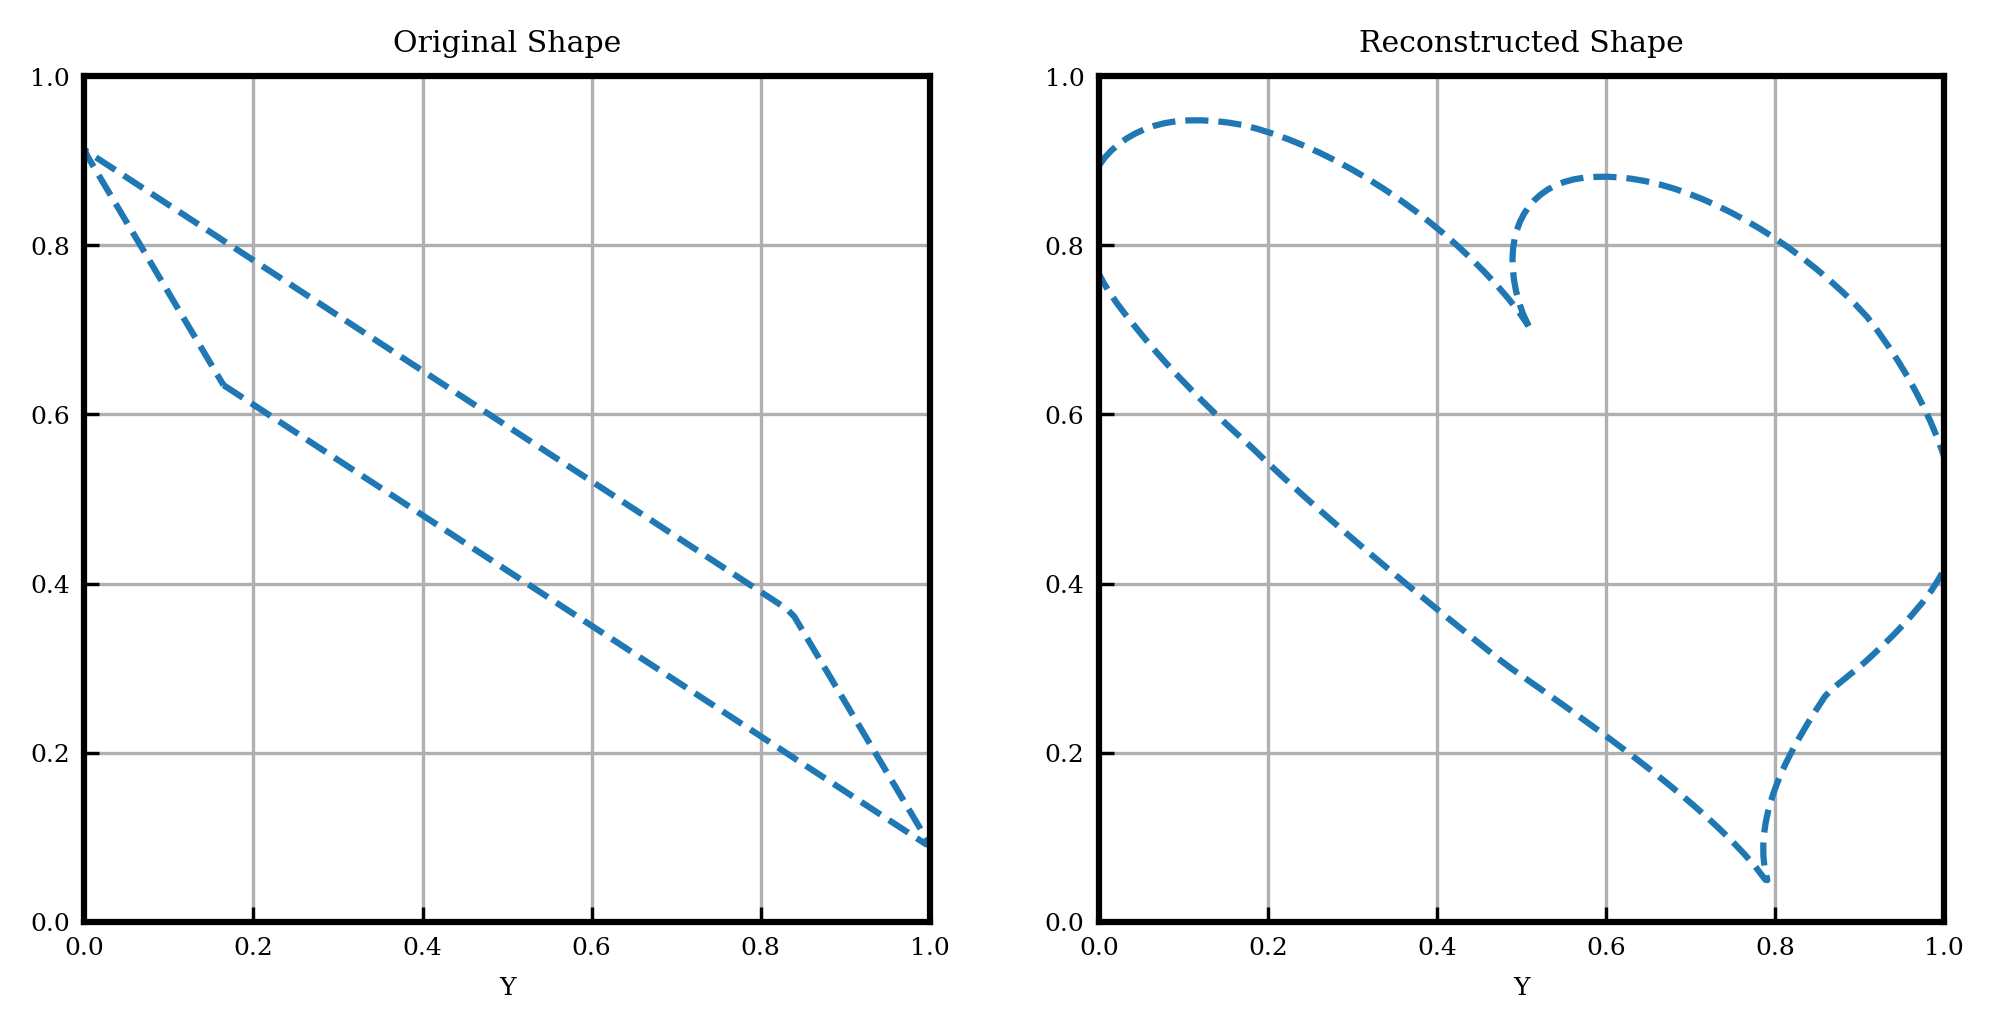

(200, 2)


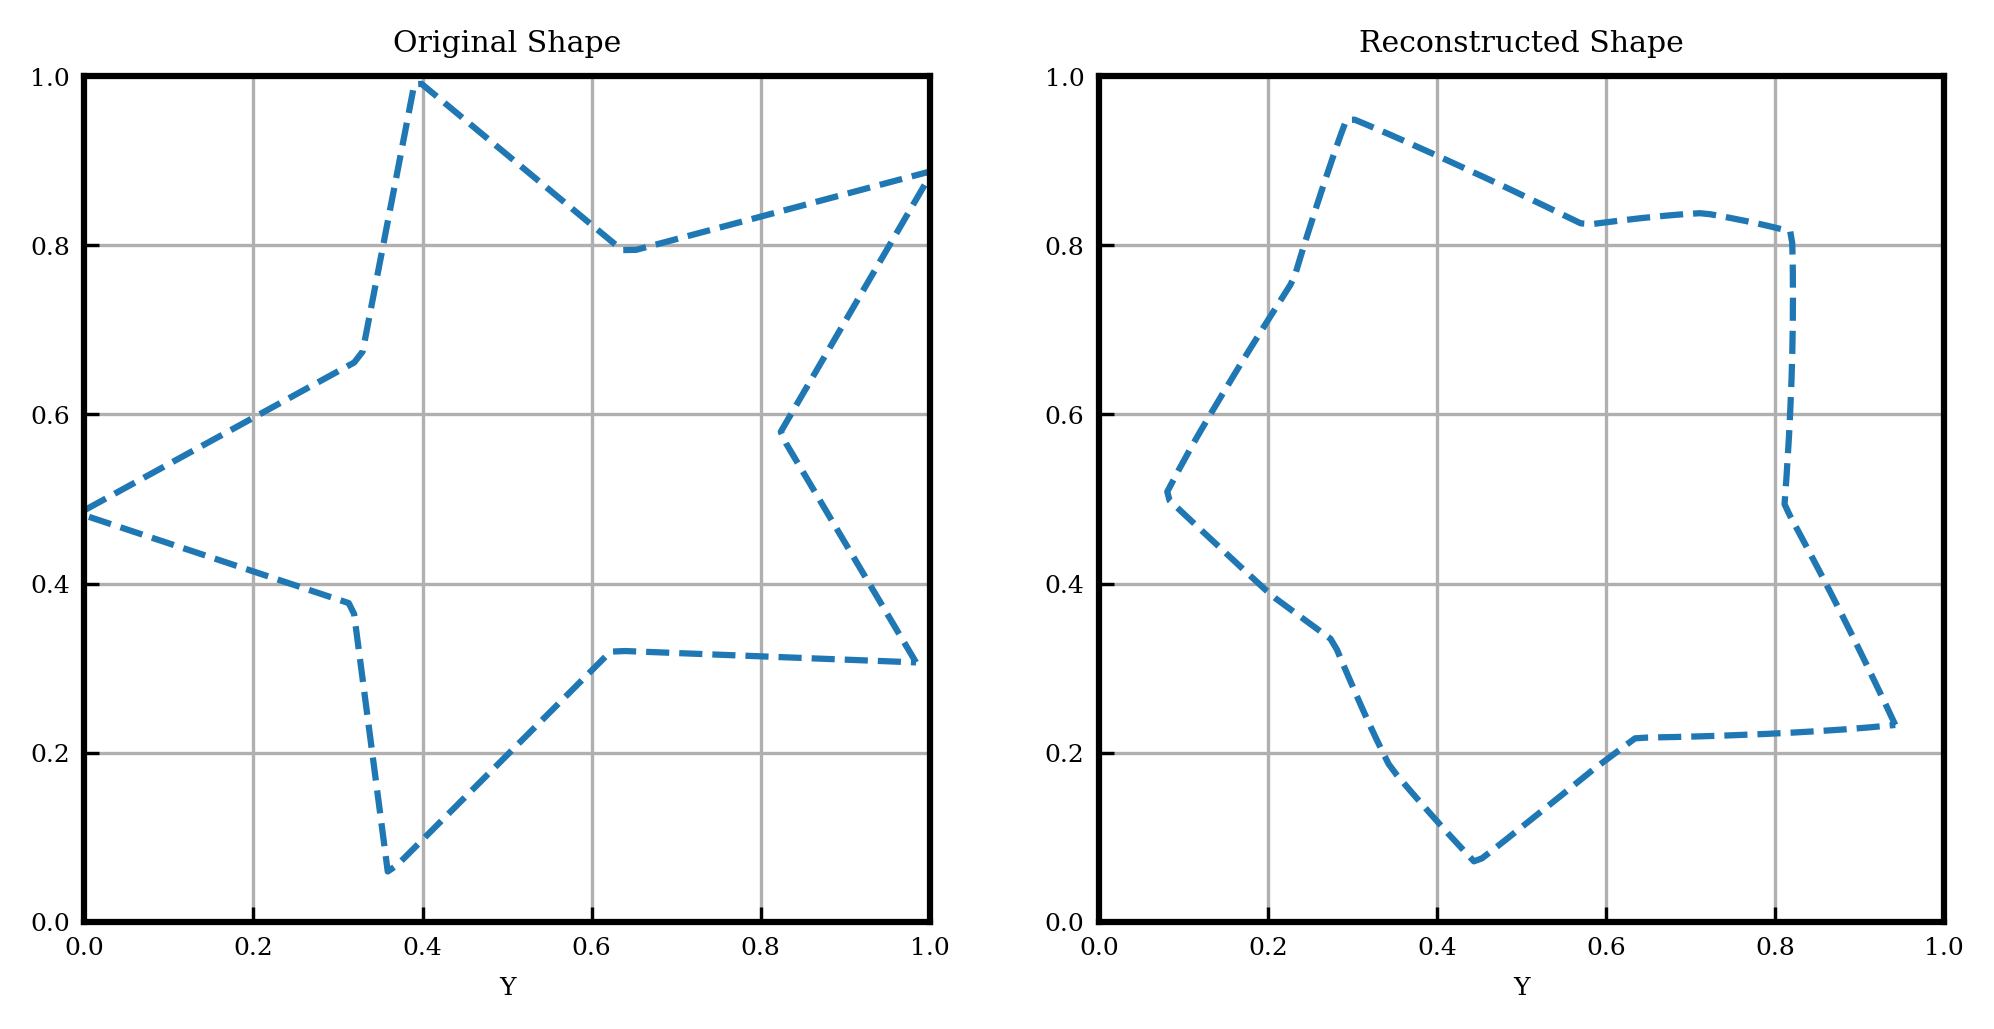

In [6]:
model.eval()

# Pass through VAE
with torch.no_grad():
    for shape in dt:
        
        recon_shape, mu, log_var = model(shape)
        recon_shape = recon_shape.squeeze(0).numpy().reshape(-1,2)

        orig_shape = shape.squeeze(0).numpy().reshape(-1,2)
        print(orig_shape.shape)
        # Plot Original vs. Reconstructed
        fig, axs = plt.subplots(1, 2, figsize=(8,4))
        for ax in axs:
            ax.set_xlim(0, 1)  # Set x-axis limits from 0 to 1
            ax.set_ylim(0, 1)  # Set y-axis limits from 0 to 1
            ax.set_aspect('equal')  # Ensure square aspect ratio
            ax.grid(True)  # Optional: Add a grid for better visualization

        axs[0].plot(orig_shape[:, 0], orig_shape[:, 1], '--', label="Original")
        axs[0].set_title("Original Shape")
        axs[0].set_xlabel('X')
        axs[0].set_xlabel('Y')
        axs[0].set_aspect('equal')

        axs[1].plot(recon_shape[:, 0], recon_shape[:, 1],'--', label="Reconstructed",markersize = 1)
        axs[1].set_title("Reconstructed Shape")
        axs[1].set_xlabel('X')
        axs[1].set_xlabel('Y')
        axs[1].set_aspect('equal')

        plt.show()



In [7]:
model = torch.load(r'/Users/joshuahellewell/Desktop/02-msc/01-modules/MSc Project - 771952/03-results/models/01042025_training/model_002/vae_epoch_1000_mse1061.3.pt')

/var/folders/g6/cp4y9yrj70746qd9t6j1yj2r0000gn/T/ipykernel_19876/2581659109.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(r'/Users/joshuahellewell/D

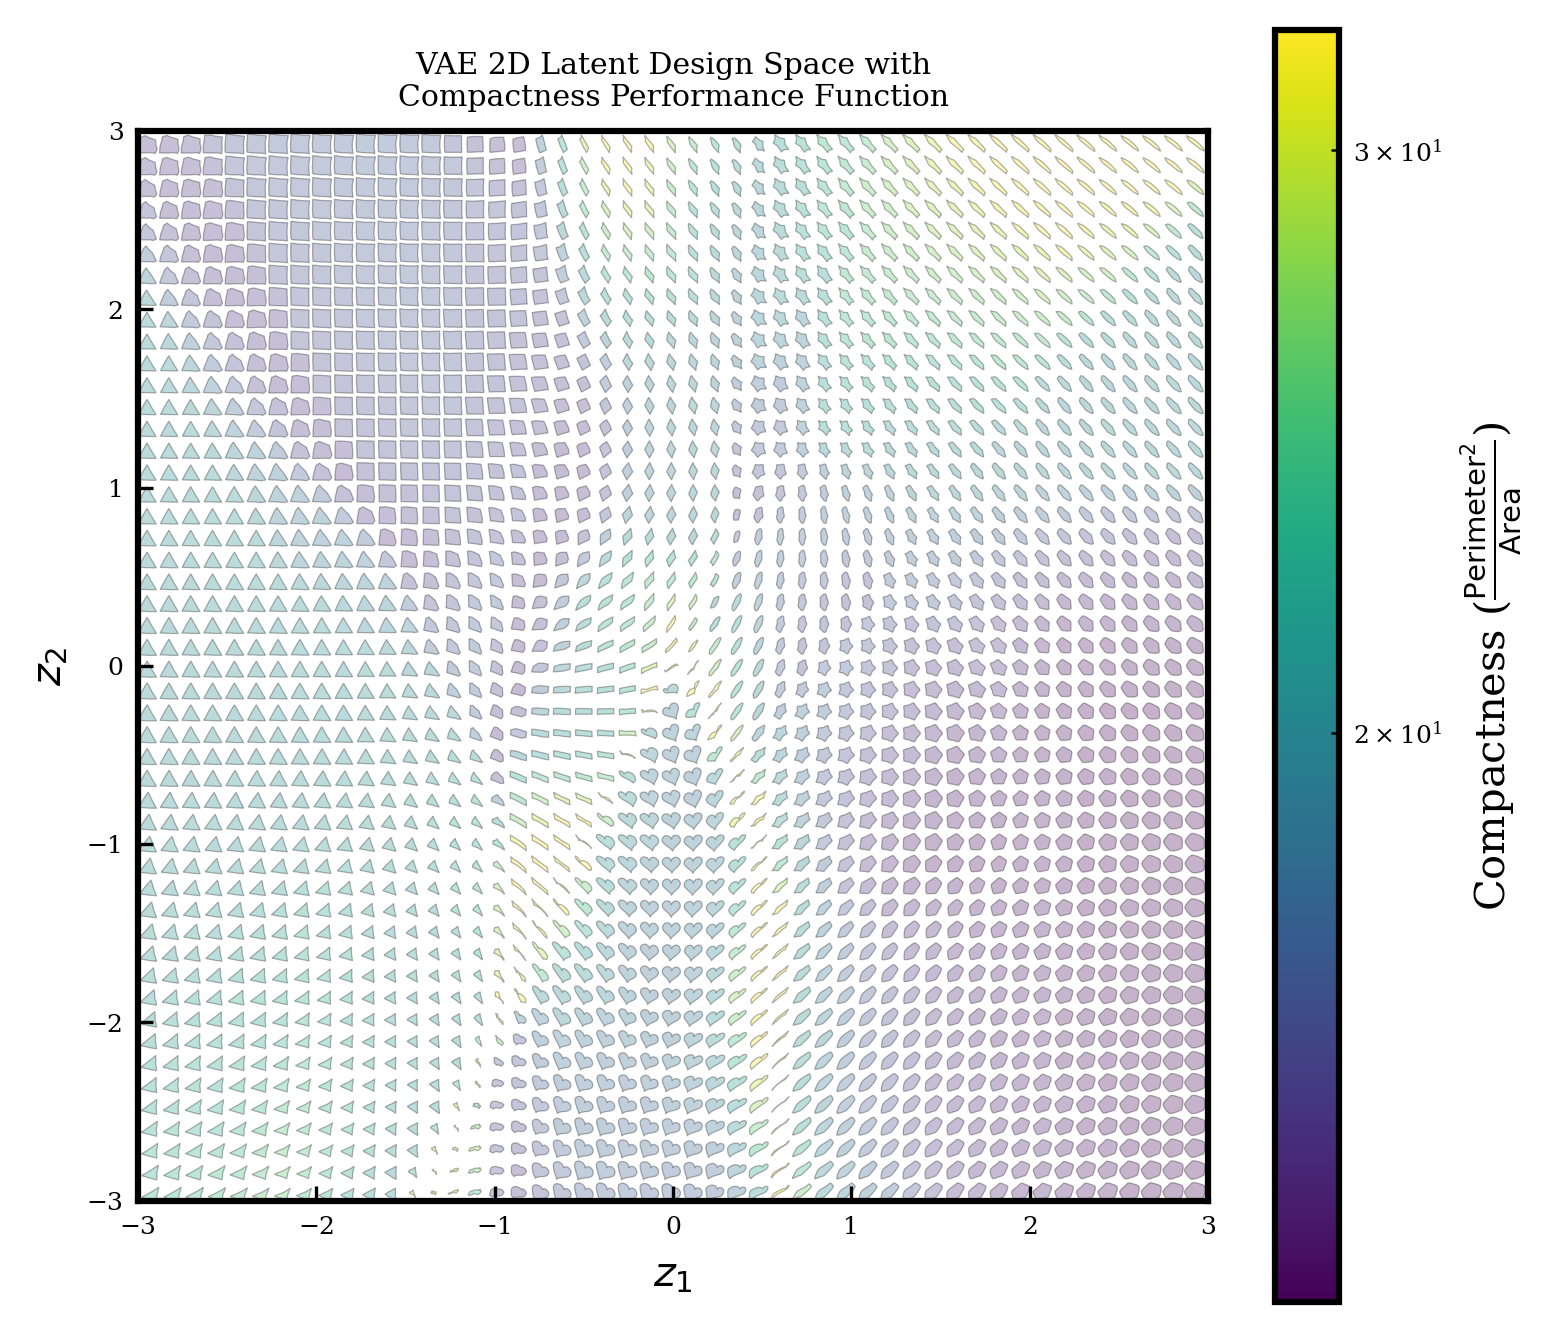

In [8]:
import matplotlib.cm as cm
import matplotlib.colors as colors

latent_dim = model.latent_dim
grid_size = 50
z_min,z_max = -3.0,3.0

resolution = 200

z1 = np.linspace(z_min,z_max,grid_size)
z2 = np.linspace(z_min,z_max,grid_size)

z_grid = np.array(np.meshgrid(z1,z2)).T.reshape(-1,2)

cmap = cm.viridis  # You can change this to 'plasma', 'coolwarm', etc.

# Compute min/max compactness for color scaling
compactness_values = []
z_values = []
for z in z_grid:
    with torch.no_grad():
        z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0)
        z_values.append(z_tensor)
        decoded_shape = model.decoder(z_tensor).detach().numpy().reshape(resolution, 2)
        compactness = vae.Metrics(decoded_shape).compute_compactness()
        compactness_values.append(compactness)

compactness_min = np.percentile(compactness_values,5)
compactness_max = np.percentile(compactness_values,95)

# Define normalization
norm = colors.LogNorm(vmin=compactness_min, vmax=compactness_max) 

# Create figure and axis
fig, ax = plt.subplots(figsize = (5,5))
ax.set_xlim(z_min, z_max)
ax.set_ylim(z_min, z_max)
ax.set_aspect('equal')
ax.set_xlabel('$z_1$',fontsize=10)
ax.set_ylabel('$z_2$',fontsize=10)
ax.set_title('VAE 2D Latent Design Space with\nCompactness Performance Function')
plt.tight_layout()


shape_scale = 0.1
for z in z_grid:
    z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0)
    decoded_shape = model.decoder(z_tensor).detach().numpy().reshape(resolution, 2)
    
    compactness = vae.Metrics(decoded_shape).compute_compactness()
    decoded_shape *= shape_scale
    
    # Map compactness to an RGBA color tuple
    color_value = cmap(norm(compactness))  # This ensures an RGBA tuple (r, g, b, a)

    # Plot shape
    ax.fill(decoded_shape[:, 0] + z[0], decoded_shape[:, 1] + z[1],
            color=color_value, alpha=0.3, edgecolor='black',linewidth = 0.3)

# Add colorbar reflecting the full compactness range
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"Compactness ($\frac{\text{Perimeter}^2}{\text{Area}}$)",fontsize=10)

plt.show()


### PCA Comparison

In [9]:
pca = PCA(2)
pca_z = pca.fit_transform(sh)

-7.0216085963646195 7.303261694734906
-5.641442167633604 4.338708851577926


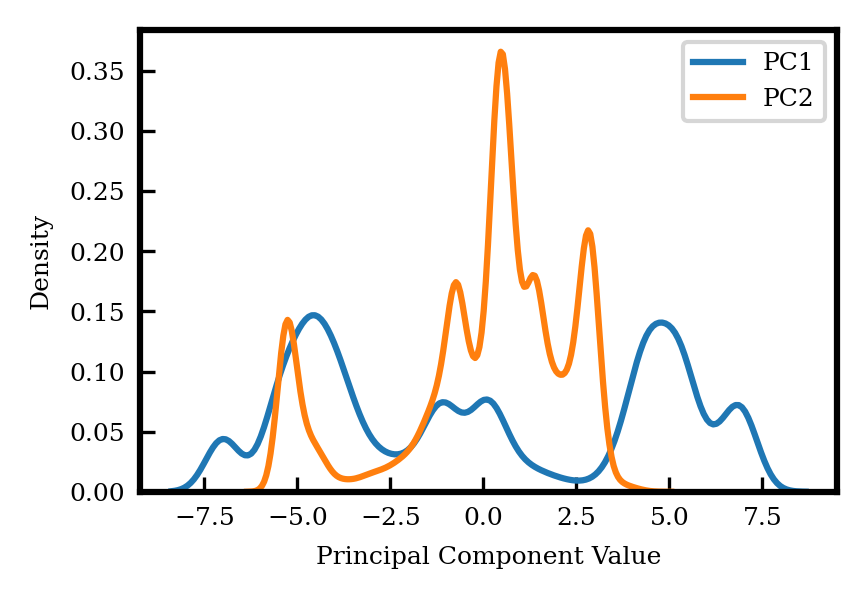

In [10]:
z1_pca  = pca_z[:,0]
z2_pca  = pca_z[:,1]

print(z1_pca.min(),z1_pca.max())
print(z2_pca.min(),z2_pca.max())

sns.kdeplot(z1_pca,label = 'PC1')
sns.kdeplot(z2_pca,label = 'PC2')
plt.xlabel('Principal Component Value')
plt.legend()
plt.show()

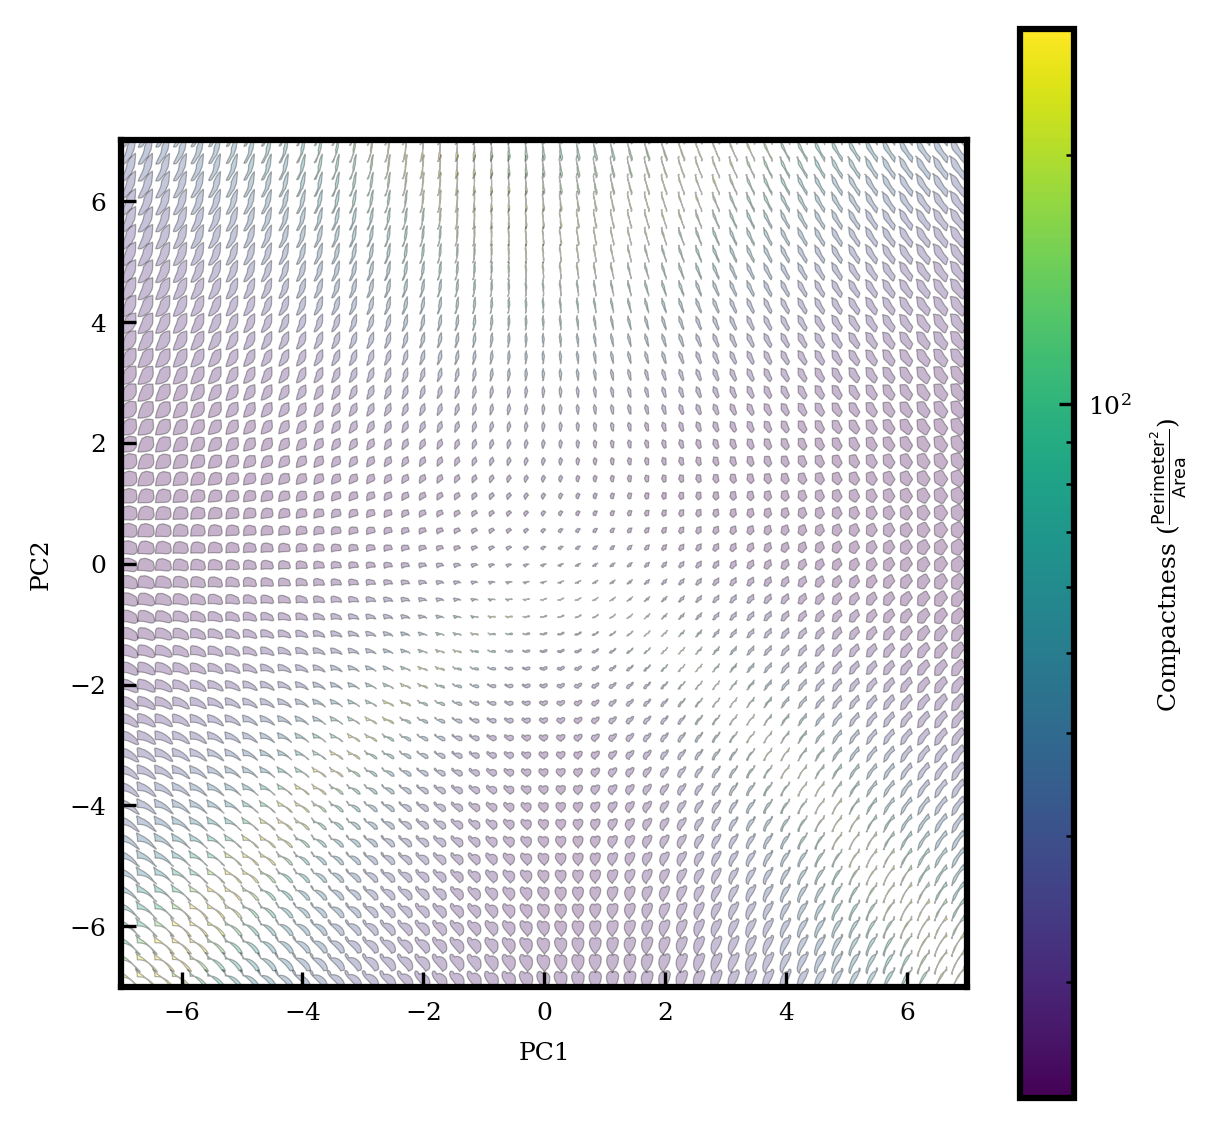

In [11]:
import matplotlib.cm as cm
import matplotlib.colors as colors

latent_dim = model.latent_dim
grid_size = 50
z_min,z_max = -7.0,7.0

resolution = 200

z1 = np.linspace(z_min,z_max,grid_size)
z2 = np.linspace(z_min,z_max,grid_size)

z_grid = np.array(np.meshgrid(z1,z2)).T.reshape(-1,2)

cmap = cm.viridis  # You can change this to 'plasma', 'coolwarm', etc.

# Compute min/max compactness for color scaling
compactness_values = []
z_values = []
for z in z_grid:
    recon_ = pca.inverse_transform(z).reshape(200,2)
    compactness = vae.Metrics(recon_).compute_compactness()
    compactness_values.append(compactness)

compactness_min = np.percentile(compactness_values,5)
compactness_max = np.percentile(compactness_values,95)

# Define normalization
norm = colors.LogNorm(vmin=compactness_min, vmax=compactness_max) 

# Create figure and axis
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlim(z_min, z_max)
ax.set_ylim(z_min, z_max)
ax.set_aspect('equal')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.tight_layout()


shape_scale = 0.25
for z in z_grid:
    decoded_shape = pca.inverse_transform(z).reshape(200,2)
    
    compactness = vae.Metrics(decoded_shape).compute_compactness()
    decoded_shape *= shape_scale
    
    # Map compactness to an RGBA color tuple
    color_value = cmap(norm(compactness))  # This ensures an RGBA tuple (r, g, b, a)

    # Plot shape
    ax.fill(decoded_shape[:, 0] + z[0], decoded_shape[:, 1] + z[1],
            color=color_value, alpha=0.3, edgecolor='black',linewidth = 0.3)

# Add colorbar reflecting the full compactness range
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"Compactness ($\frac{\text{Perimeter}^2}{\text{Area}}$)")

plt.show()
